<a href="https://colab.research.google.com/github/gylam/siads696-sprsum2024-team05/blob/main/6_unsupervised_learning_nmf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description**

Apply unsupervised learning topic modeling using NMF on single-theme climate change documents.

Identify optimal k (number of topics), using topic coherence as metric


In [ ]:
!pip install wordcloud

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/_Course materials/S5M1-2 696 - Milestone II/Milestone 2 shared folder/'

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Read in documents

In [ ]:
### Read in documents that are only tagged with the theme "Climate Change and Environment"

# Read in all documents with a single theme with at least 100 words - preprocessed
df_single_theme = pd.read_pickle(base_path + 'data/m2_dataset_clean.pkl')

# Subset to data with the theme "Climate Change and Environment"
df_climate = df_single_theme[df_single_theme['theme_name'] == 'Climate Change and Environment']

# Remove "climate" and "change" from cleaned_text
df_climate['cleaned_text_v2'] = df_climate['cleaned_text'].str.replace(r'climate|change', '', regex = True)
print(df_climate.shape)
df_climate.head()

<ipython-input-4-4e2dbbb8da04>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_climate['cleaned_text_v2'] = df_climate['cleaned_text'].str.replace(r'climate|change', '', regex = True)


(1039, 19)


,report_id,theme_id,theme_name,title,text,combined_text,url,latitude,longitude,country_iso3,country_name,date_created,source_id,source_name,format,word_count,len_text,cleaned_text,cleaned_text_v2
448,287652,[4588],Climate Change and Environment,Thousands of Bangladeshis urge action on climate,"DHAKA, Nov 18 (Reuters) - Thousands of Banglad...",Thousands of Bangladeshis urge action on clima...,https://reliefweb.int/node/287652,23.84,90.270,bgd,Bangladesh,2008-11-18T05:00:00+00:00,1456,Reuters - Thomson Reuters Foundation,News and Press Release,233.0,1426,thousands urge action climate thousands urge b...,thousands urge action thousands urge big poll...
214,310640,[4588],Climate Change and Environment,New World Bank report calls for action to redu...,The study focuses on two drought-prone regions...,New World Bank report calls for action to redu...,https://reliefweb.int/node/310640,22.76,79.280,ind,India,2009-05-25T04:00:00+00:00,1220,World Bank,News and Press Release,1254.0,8324,report call action reduce climate change impac...,report call action reduce impact area study ...
666,316269,[4588],Climate Change and Environment,Global: Twelve countries on climate change hit...,"JOHANNESBURG, 8 July 2009 (IRIN) - The World B...",Global: Twelve countries on climate change hit...,https://reliefweb.int/node/316269,23.84,90.270,bgd,Bangladesh,2009-07-08T04:00:00+00:00,1414,The New Humanitarian,News and Press Release,337.0,1923,global country climate change make list main t...,global country make list main threat arise ...
424,319242,[4588],Climate Change and Environment,Government must listen to Pacific leaders on t...,Government must listen to Pacific leaders on t...,Government must listen to Pacific leaders on t...,https://reliefweb.int/node/319242,-17.71,178.065,fji,Fiji,2009-08-04T04:00:00+00:00,2007,Oxfam,News and Press Release,510.0,3240,listen leader trade climate change listen lead...,listen leader trade listen leader trade ne...
262,322734,[4588],Climate Change and Environment,Final statement: From Kathmandu to Copenhagen,A Vision for Addressing Climate Change Risks a...,Final statement: From Kathmandu to Copenhagen ...,https://reliefweb.int/node/322734,28.25,83.940,npl,Nepal,2009-09-01T04:00:00+00:00,551,Government of Nepal,News and Press Release,751.0,5098,final statement host inaugurate conference con...,final statement host inaugurate conference con...


# Non-negative matrix factorization (NMF)

* Run NMF with several k values from 1-10
* Use coherence scores (comparing different approaches for calculating) to find optimal k
* Also output top words associated with each topic.

In [ ]:
# Function to generate tokens as list of lists
def generate_tokens(text_df, text_col = 'cleaned_text_v2'):
  # Get tokenized words as list of lists - one list for each document
  tokenized_text = []
  for curr_text in text_df[text_col]:
    curr_tokens = [curr_word for curr_word in curr_text.split()]
    tokenized_text.append(curr_tokens)
  return tokenized_text

# Function to generate corpus and dictionary
# Reference: https://stackoverflow.com/questions/49527668/understanding-how-words-are-stored-in-dictionary-of-gensim-corpus-after-using-g
def generate_corpus_dict(text_df):
  # Get tokenized words as list of lists - one list for each document
  tokenized_text = generate_tokens(text_df)

  # Create corpus and dictionary from tokenized_text
  text_dict = Dictionary(tokenized_text)
  corpus = [text_dict.doc2bow(text) for text in tokenized_text]

  return text_dict, corpus

# Function to calculate coherence score, given text, metric, k, and number of top words
# Reference: SIADS 543 Jupyter notebook - MADS_Unsupervised_Learning_Module_3.ipynb
def calc_coherence_scores_topic(text_df, metric,
                                text_col = 'cleaned_text_v2',
                                k = 5, top_n = 10):

  tf = TfidfVectorizer(min_df = 10).fit(text_df[text_col])
  df_vectorized = tf.transform(text_df[text_col])
  feature_names = tf.get_feature_names_out()

  nmf = NMF(n_components = k, init = 'nndsvd', max_iter = 500).fit(df_vectorized)
  W = nmf.fit_transform(df_vectorized) # document-topic matrix
  H = nmf.components_ # topic-term matrix

  top_terms_all = [] # Stores top words for each topic

  # Identify top_n words in each topic for current k
  for topic_index in range(0, k):
      top_indices = np.argsort(H[topic_index, :])[::-1]
      top_terms = []
      for term_index in top_indices[0:top_n]:
          top_terms.append(feature_names[term_index])
      top_terms_all.append(top_terms)

  # Generate tokens, corpus, and dictionary
  tokenized_text = generate_tokens(text_df)
  text_dict, corpus = generate_corpus_dict(text_df)

  # When done compiling top words for each topic, calculate coherence score per topic
  curr_model = CoherenceModel(topics = top_terms_all, texts=tokenized_text,
                    corpus=corpus, dictionary=text_dict, coherence=metric)
  curr_score_by_topic = curr_model.get_coherence_per_topic()

  # Create dataframe with topics and their score
  curr_row_by_topic = pd.DataFrame(list(zip(top_terms_all, curr_score_by_topic)),
                                  columns = ['topic_keywords', 'topic_score'])
  curr_row_by_topic['k'] = k
  curr_row_by_topic['topic_num'] = np.arange(len(curr_row_by_topic))
  curr_row_by_topic['coherence_type'] = metric

  return curr_row_by_topic

In [ ]:
# NMF on single-theme documents
top = 10 # Print top 10 words associated with topic
metric_list = ['u_mass', 'c_uci'] # Include the most commonly accepted coherence methods
coherence_single_by_topic = pd.DataFrame(columns = ['k', 'topic_num', 'topic_keywords', 'coherence_type', 'topic_score'])

for k in range(1, 11):
  # For each k and metric, calculate top words in topic and coherence score per topic
  for curr_metric in metric_list:
    curr_row_by_topic = calc_coherence_scores_topic(df_climate, curr_metric, k = k, top_n = top)
    # Add dataframe to overall dataframe
    coherence_single_by_topic = pd.concat([coherence_single_by_topic, curr_row_by_topic])


In [ ]:
# Generate table of mean k with sd
df_k = pd.read_csv(base_path + 'data/gl_test/coherence_single_by_topic_nndsvd_iter500_2metrics.csv')
df_k_grp = df_k.groupby(['k', 'coherence_type'])['topic_score'].agg(['mean', 'std']).reset_index()

df_k_grp_wide = pd.pivot_table(df_k_grp, values = ['mean', 'std'],
                               index = ['k'],
                               columns = ['coherence_type']).reset_index().round(2)
df_k_grp_wide

k  mean          std       
coherence_type     c_uci u_mass c_uci u_mass
0                1 -0.10  -0.61   NaN    NaN
1                2  0.22  -0.85  0.05   0.03
2                3 -0.34  -1.72  1.16   1.52
3                4  0.38  -1.04  0.23   0.27
4                5  0.53  -1.08  0.45   0.23
5                6  0.53  -1.00  0.39   0.25
6                7  0.51  -1.00  0.28   0.28
7                8  0.58  -1.06  0.56   0.23
8                9  0.68  -1.04  0.47   0.24
9               10  0.70  -1.09  0.44   0.19

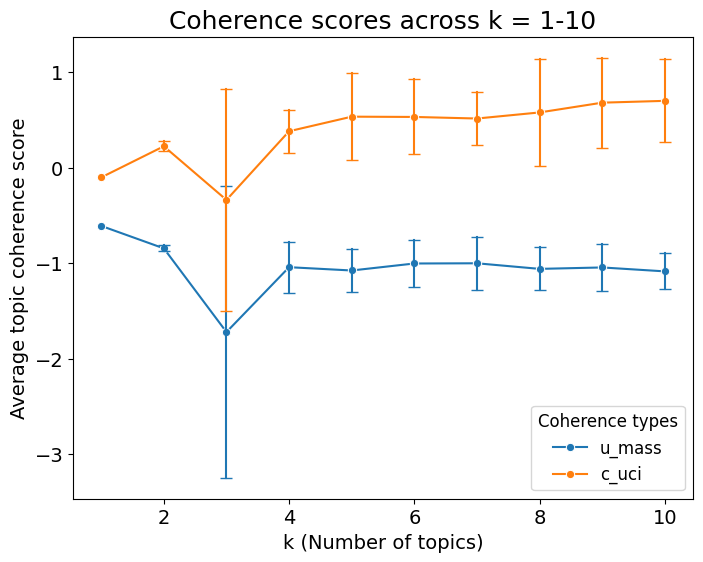

In [ ]:
# Plot coherence score vs k, to identify optimal number of topics

# Make line graph with coherence score across k=1-10 and the 2 methods
plt.figure(figsize=(8, 6))
lineplot = sns.lineplot(data = coherence_single_by_topic, x = 'k', y = 'topic_score', hue = 'coherence_type',
                        marker = 'o',
                        estimator = 'mean', errorbar = 'sd', err_style='bars', err_kws={'capsize':4})

plt.legend(title='Coherence types', title_fontsize = 12, fontsize=12)
plt.xlabel('k (Number of topics)', fontsize=14);
plt.ylabel('Average topic coherence score', fontsize=14);
plt.title('Coherence scores across k = 1-10', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)

fig = lineplot.get_figure()
#fig.savefig(base_path + "data/gl_test/lineplot_nndsvd_iter500_2methods_v2.png")

In [ ]:
# Examine large standard deviation for k = 3
# Look at individual per-topic coherence scores and top words for k = 3 vs k = 4
coherence_k_3_4 = coherence_single_by_topic[(coherence_single_by_topic['k'] == 3) | (coherence_single_by_topic['k'] == 4)]

# Concatenate topic_keywords into a single string
coherence_k_3_4['topic_keywords_str'] = coherence_k_3_4['topic_keywords'].apply(lambda x: ' '.join(x))

# Create pivot table with UCI and UMass scores in separate columns
coherence_k_3_4_wide = pd.pivot_table(coherence_k_3_4,
                                      values = 'topic_score',
                                      index = ['k', 'topic_num', 'topic_keywords_str'],
                                      columns = ['coherence_type']).reset_index()
coherence_k_3_4_wide

<ipython-input-9-b33670c6d031>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coherence_k_3_4['topic_keywords_str'] = coherence_k_3_4['topic_keywords'].apply(lambda x: ' '.join(x))


coherence_type,k,topic_num,topic_keywords_str,c_uci,u_mass
0,3,0,project support country development adaptation...,0.397979,-0.800188
1,3,1,flood water people sea rise temperature year r...,0.259031,-0.881738
2,3,2,forest tree refugee oil plant environmental ca...,-1.672149,-3.479628
3,4,0,project support country development adaptation...,0.489156,-0.882576
4,4,1,flood water people sea rise temperature year r...,0.259031,-0.881738
5,4,2,forest tree refugee plant camp community land ...,0.638228,-0.967174
6,4,3,oil spill vessel environmental tanker operatio...,0.135229,-1.436392


Comments on per-topic coherence scores
* Topic score significantly drops for final topic - most noticeable in k=3
* Topic 3 gets split into 2 topics when k=4, resulting in higher topic scores



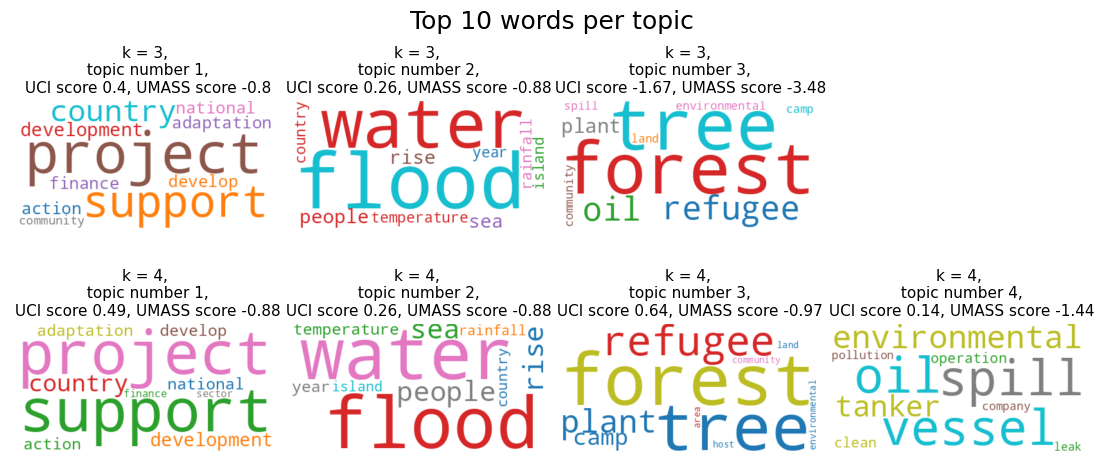

In [ ]:
# Generate word clouds of top words in topics, for optimal k (k=3 vs k=4)

fig, axes = plt.subplots(nrows = len(coherence_k_3_4_wide['k'].unique()),
                         ncols = len(coherence_k_3_4_wide['topic_num'].unique()),
                         figsize = (11,5),
                         tight_layout = True,
                         )
min_k = min(coherence_k_3_4_wide['k'])

# Loop through each topic and generate 1 plot with subplots for each k
for i, curr_row in coherence_k_3_4_wide.iterrows():
  curr_keywords = curr_row['topic_keywords_str']
  curr_k = curr_row['k']
  curr_row_num = curr_k - min_k
  curr_topic_num = curr_row['topic_num']
  curr_ax = axes[curr_row_num, curr_topic_num]

  # Create and generate a word cloud image:
  wordcloud = WordCloud(background_color = 'white',
                        colormap='tab10', #height = 500
                        ).generate(curr_keywords)

  # Generate subplot for wordcloud
  curr_ax.imshow(wordcloud, interpolation='bilinear')
  curr_ax.set_title(f'k = {str(curr_k)},\n topic number {curr_topic_num+1}' + \
                    f',\n UCI score {round(curr_row["c_uci"], 2)}, UMASS score {round(curr_row["u_mass"], 2)}',
                    fontsize = 11)
  curr_ax.axis("off")

# Remove subplot for k = 3, topic_num = 3 (does not exist)
axes[0, 3].remove()

# Display the generated image:
fig.suptitle('Top 10 words per topic', fontsize = 18)
plt.show()
#fig.savefig(base_path + "data/gl_test/wordclouds_nmf_k_3_4_v2.png")